# Fonction tester

This file main goal is to test function and classes for later use in training.
Is ignore entirely during the training

### Import Lib

In [1]:
# General Libs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import keras
import datetime
from contextlib import redirect_stdout

# Current files
from generator import Diff_Generator, Basic_Generator, Up_and_Down_Generator, Full_Diff_Generator
from preprocess import ProdKernel, FKernel, VarSuppression, Zero_One,  Level_Normalizer, Normalizer, DictPrepross
from generator import FC_Generator

from utils import Load_FLX_dict, Plot_Batch
from CST import CST

data_folder=  'Data2'#sCST.Data_folder(CST)
model_folder = CST.Model_folder(CST)
log_folder = CST.Log_folder(CST)

Using TensorFlow backend.
/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.24.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


### Prepross

In [2]:
seed=0
batch_size=32
np.random.seed(seed)
D = [Load_FLX_dict()]
D2 = []
##### Kernels
Klist0 =[]
def identity(x):
    return(x)
def Log(x): 
    return(np.log(x))
def Plank(x):
    return(1/(np.exp(1/x) -1 ))

Klist0 = [] #[ FKernel(Log, ['q'], 1), FKernel(Plank, ['t'], 250)]
Klist = []
#Klist = [FKernel(func=identity, var=['t'])]
Klist = Klist + [ProdKernel([('pl','ts')])]
# V
V = [VarSuppression(['pl', 'rl', 'ri','ts'])]

fit_genator = Up_and_Down_Generator(folder=data_folder, batch_size=10*batch_size, train=True, preprocess_x=D+Klist0)
normal_generator = Basic_Generator(folder=data_folder, batch_size=batch_size)

#D2 = [DictPrepross(['o3','pl','q','t'], [Level_Normalizer(False),Level_Normalizer(True), Level_Normalizer(True),Level_Normalizer(False)] )]
D2 = [DictPrepross(['o3','pl','q'], [Level_Normalizer(False),Level_Normalizer(True), Level_Normalizer(True)] )]
D3_0 = [DictPrepross(['Logq'], [Normalizer()] )]
D4 = [DictPrepross(['Logq'], [Level_Normalizer(False)] )]
D3 = D3_0+D4

D2[0]['pl'].fit(fit_genator[0][0][:,:,3])
D2[0]['o3'].fit(fit_genator[0][0][:,:,2])
D2[0]['q'].fit(fit_genator[0][0][:,:,4])
#D3[0]['Logq'].fit(fit_genator[0][0][:,:,-1])
#D3[1]['Logq'].fit(fit_genator[0][0][:,:,-1])

del(normal_generator)
del(fit_genator)

##### Full Preprocessing :
#FP = Klist0 + D + Klist + D2  + D3 + V 
FP = Klist0 + D + Klist + D2  +  V 

##### b_size
batch_size= 64


train_generator =  Full_Diff_Generator(folder=data_folder, batch_size=batch_size, train=True, 
                                         preprocess_x=FP, chosen_var=['flxd', 'flxu'], shuffle=1)
validation_generator = Full_Diff_Generator(folder='Data', batch_size=batch_size, train=False, 
                                             preprocess_x=FP, chosen_var=['flxd', 'flxu'], shuffle=1, custom_b_p_e= 500)
#cold_generator = Up_and_Down_Generator(folder=data_folder, batch_size=batch_size, train=True, preprocess_x=FP, shuffle=1)

header_x = train_generator.used_variables
header_y = train_generator.new_variables_pred

in_channel=len(header_x)
o_channel = len(header_y)
lev=72

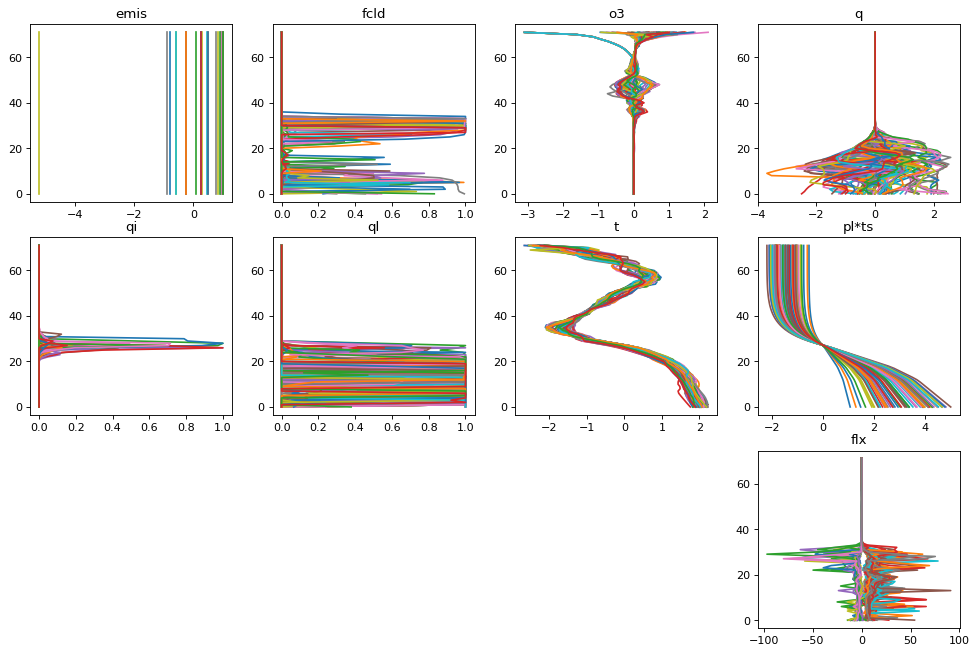

In [3]:
x,y = train_generator[0]
Plot_Batch(x,y,header_x)

### Model construct

In [4]:
from architectures import AE, Unet_Act_Double
import keras
from architectures_simples import Upsampler
from architectures import Unet_Act_Simple,  Bidir_Casual_Conv
from architectures_simples import Upsampler
from architectures_utils import total_loss, flxd_loss, flxu_loss, dfdts_loss, LossHistory,  Generate_Log
from architectures_utils import Activation_Generator
import keras.backend as K
from keras import optimizers
from keras.layers import Dropout
import datetime

list_of_filters_ae =  [[64, 128, 128], [50, 50, 75, 75, 100, 100], [40, 40], [50, 50, 100, 100, 200, 200], [300, 50, 2]]
list_of_kernel_ae =  [[10, 10, 5], [2, 5, 2, 5, 2, 4], [], [3, 4, 3, 5, 3, 6], [5, 5, 3]]
list_of_activations_ae =  [['elu', 'elu', 'elu'], ['elu', 'elu', 'elu', 'elu', 'elu', 'elu'], ['sigmoid', 'sigmoid'], ['elu', 'elu', 'elu', 'elu', 'elu', 'elu'], ['elu', 'elu', 'linear']]

params_ae = [0.1]

M_Up = Upsampler(avg=5, pooling=22, input_shape=(lev, in_channel))
M_unet =  Unet_Act_Double(list_of_kernel_ae, list_of_filters_ae, list_of_activations_ae,
                         params_ae, Div=3, lev=CST.lev(CST), in_channel=in_channel)

M = keras.models.Sequential()
M.add(M_Up); M.layers[-1].name = 'Upsampler'
M.add(M_unet); M.layers[-1].name = 'Unet'
M_unet.summary()

/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures_simples.py:76: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(22, padding="same", strides=5)`
  Avg = AveragePooling1D(pooling, padding='same', stride=avg)(Up)
/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:130: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(2, padding="same", name="AVG_100", strides=2)`
  Conv_l1.append(AveragePooling1D(2, padding='same', stride=2, name=Name('AVG', i+100))(Conv_l1[-1]))
/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:130: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(2, padding="same", name="AVG_101", strides=2)`
  Conv_l1.append(AveragePooling1D(2, padding='same', stride=2, name=Name('AVG', i+100))(Conv_l1[-1]))
/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:130: UserWarning: Update your `Av

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Origin_Input (InputLayer)       (None, 72, 8)        0                                            
__________________________________________________________________________________________________
Conv_0 (Conv1D)                 (None, 72, 64)       5120        Origin_Input[0][0]               
__________________________________________________________________________________________________
elu_0 (ELU)                     (None, 72, 64)       0           Conv_0[0][0]                     
__________________________________________________________________________________________________
Conv_1 (Conv1D)                 (None, 72, 128)      81920       elu_0[0][0]                      
__________________________________________________________________________________________________
elu_1 (ELU

In [5]:
from keras import optimizers
from keras.losses import mean_squared_error
from architectures_utils import LossHistory, Generate_Log
import datetime

def Up_Down_loss(y_true, y_pred):
    E = flxd_loss(y_true, y_pred)
    E += flxu_loss(y_true, y_pred)
    return E

ES = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, restore_best_weights=True, baseline=35)
prefix = '20190604220531U_d'

LH = LossHistory(frequency=train_generator.batch_per_file, losses=['flxu_loss', 'flxd_loss', 'loss'])
Adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1.e-6, amsgrad=False)
M.compile(loss=Up_Down_loss, optimizer=Adam, metrics=[flxd_loss,flxu_loss])
M.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Upsampler (Model)            (None, 72, 8)             0         
_________________________________________________________________
Unet (Model)                 (None, 72, 2)             1564155   
Total params: 1,564,155
Trainable params: 1,564,155
Non-trainable params: 0
_________________________________________________________________


In [6]:
M.load_weights('TrainedModels/'+prefix)
#prefix='0'

In [7]:
from tqdm import tqdm 

def Plot_Earth(M, generator, prec):
    i=0
    MSE=[]
    for x, y in tqdm(generator):
        y0 = M.predict(x)
        MSE.append(K.get_value(Up_Down_loss(y,y0))/np.mean(np.square(y[:,:,:2])))
    MSE = np.array(MSE) 
    return(MSE)

train_generator =  Full_Diff_Generator(folder=data_folder, batch_size=1944*batch_size, train=True, 
                                         preprocess_x=FP, chosen_var=['flxd', 'flxu'], shuffle=0, custom_b_p_e=25)
V = Plot_Earth(M, train_generator, 5)
V=np.array(V)
np.save('cor'+prefix,V)

100%|██████████| 25/25 [13:37<00:00, 32.72s/it]


In [7]:
print(header_x, x.shape)

['emis', 'fcld', 'o3', 'q', 'qi', 'ql', 't', 'pl*ts'] (64, 72, 8)


In [9]:
from utils import Get_Var, reconstruct

train_generator =  Full_Diff_Generator(folder=data_folder, batch_size=1944*batch_size, train=True, 
                                         preprocess_x=FP, chosen_var=['flxd', 'flxu'], shuffle=0, custom_b_p_e=25)

#E = Get_Emis(train_generator)
T = Get_Var(train_generator, header_x, 't', 0)
Ci = Get_Var(train_generator, header_x, 'qi', 1)
Cl = Get_Var(train_generator, header_x, 'ql', 1)
xdim = train_generator.dimensions['x']
ydim = train_generator.dimensions['y']

ImportError: cannot import name 'Get_Var'

In [10]:
from utils import 
V = V.reshape(V.shape[0], ydim,xdim)
V2 = V2.reshape(V2.shape[0], ydim,xdim)
T = T.reshape(T.shape[0], ydim,xdim)
C = C.reshape(C.shape[0], ydim,xdim)
Q = Q.reshape(Q.shape[0], ydim,xdim)
V = reconstruct(V)
V2 = reconstruct(V2)
T = reconstruct(T)
C = reconstruct(C)
Q = reconstruct(Q)

(720, 4320)
(720, 4320)
(720, 4320)
(720, 4320)
(720, 4320)


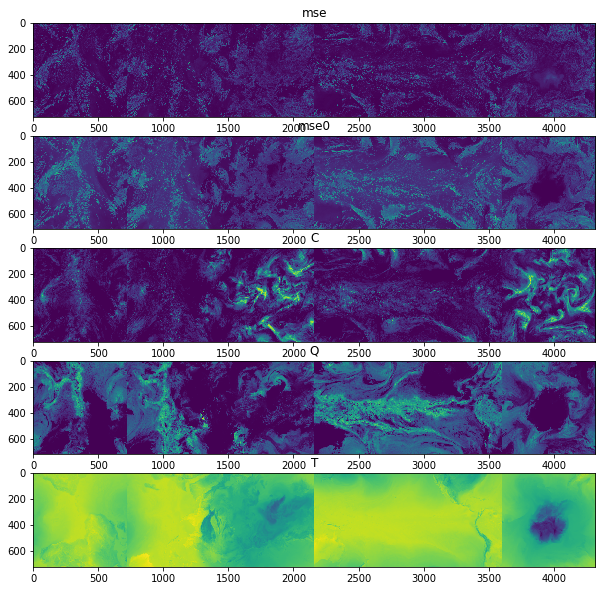

In [11]:
from utils import F_and_plots

F = F_and_plots(shape=(5,1), figsize=(15,10))
F[0].imshow(V); F[0].set_title('mse');
F[1].imshow(V2); F[1].set_title('mse0');
F[2].imshow(C); F[2].set_title('C');
F[3].imshow(Q); F[3].set_title('Q');
F[4].imshow(T); F[4].set_title('T');

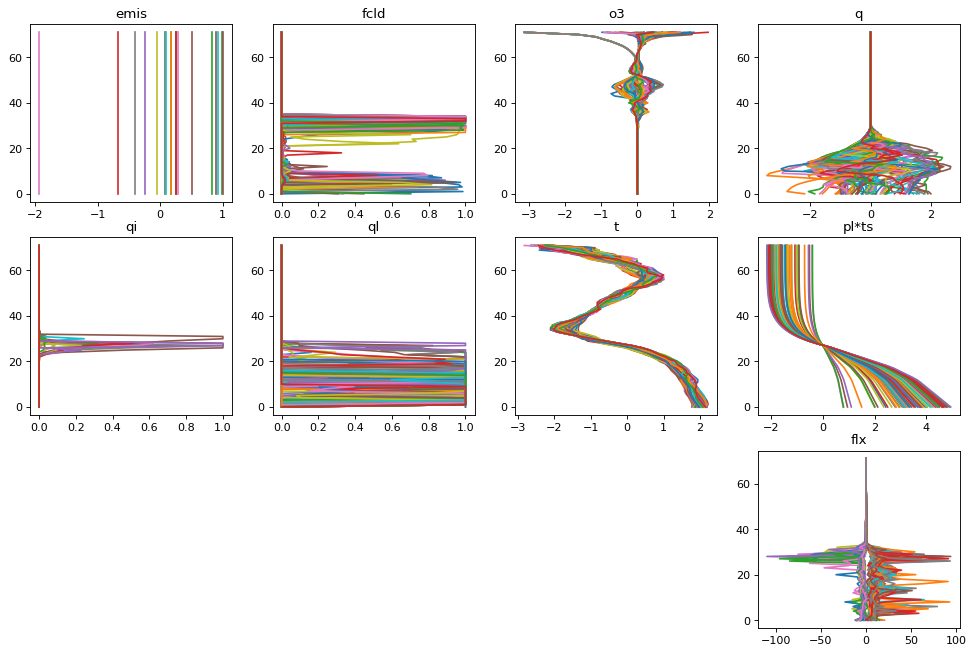

In [12]:
Plot_Batch(x,y,header_x)

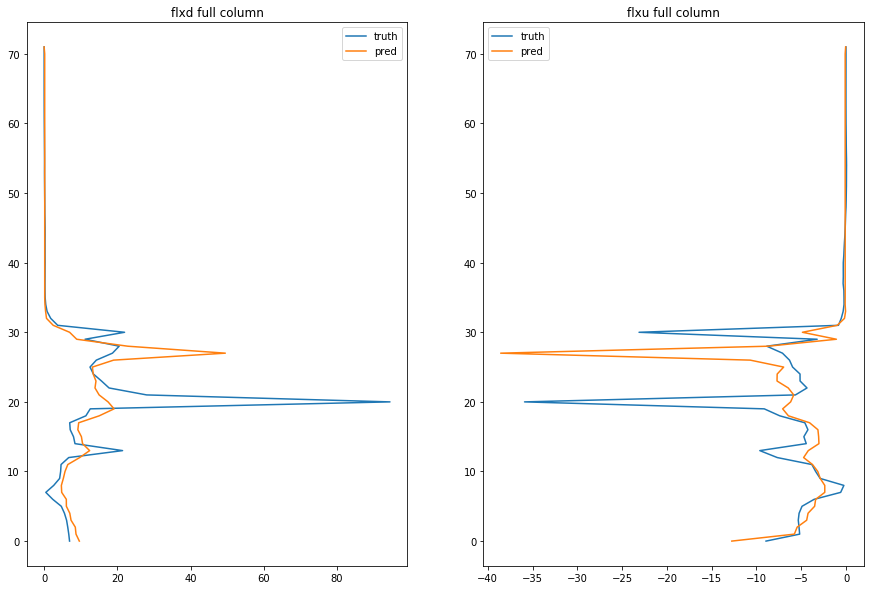

<Figure size 1080x576 with 0 Axes>

In [42]:
from utils import F_and_plots, Plot_triple_diff_separated
x,y = validation_generator[6000]
y0 =M.predict(x)
F = F_and_plots(shape=(1,2))
Plot_triple_diff_separated(F,y,y0,header_y, j=2)

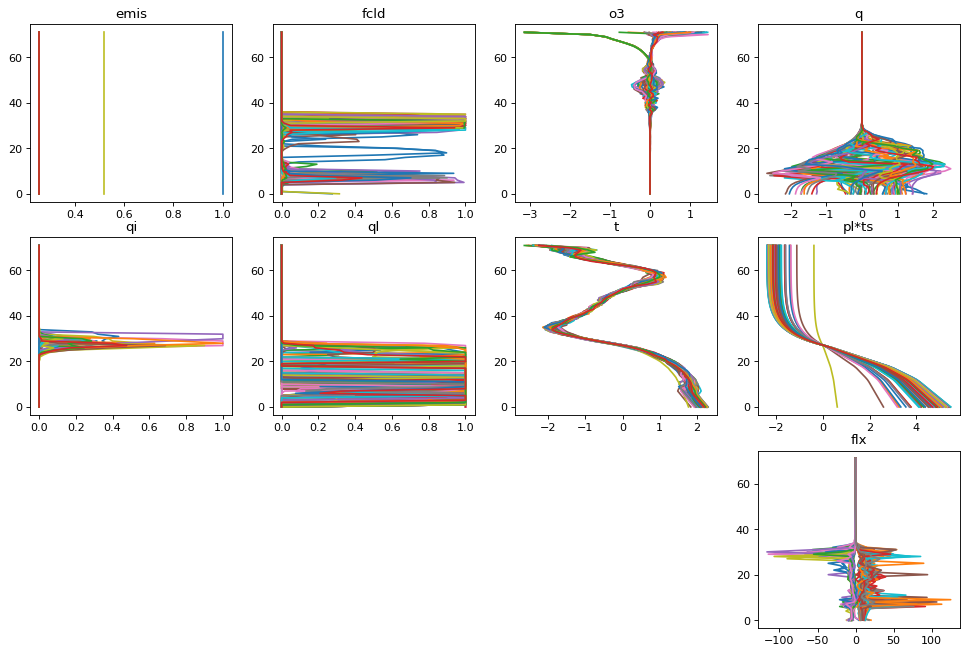

In [43]:
Plot_Batch(x,y,header_x)

In [13]:
K.get_value(Up_Down_loss(y,y0))#/np.sum(np.linalg.norm(y, axis=1),1)

array([ 11.84927  ,  72.95012  ,  25.915102 ,  11.161111 ,  36.03535  ,
       146.34158  ,  42.24119  ,   6.601989 ,  23.18644  ,  11.47748  ,
        57.832428 ,   5.307616 ,   9.494059 ,  30.447512 ,   6.0392647,
        14.561796 ,  58.280815 ,   3.7314463,  25.870934 ,  16.133802 ,
         6.0043197,  47.331078 ,  11.225072 , 204.95218  ,  22.973846 ,
         7.802394 ,  27.599472 ,  11.264574 ,   5.934491 ,  28.947704 ,
         5.5127625,  23.879875 ,   9.39247  ,   7.77465  ,  28.147509 ,
         7.25238  ,  27.555145 ,  30.185719 ,   4.4818516,  16.230942 ,
        32.863335 ,  21.742496 ,   4.6523485,   2.4929087,  84.61099  ,
        11.873862 ,  31.560173 ,  44.369316 ,  14.62064  ,  42.264904 ,
         2.700126 ,  17.77878  ,  23.778831 ,  14.674618 ,   9.149853 ,
         7.4404273,   6.2774773,   8.371607 ,   6.514961 ,  43.62371  ,
        26.970604 ,   4.6242228,  25.466682 ,  64.91415  ], dtype=float32)

In [37]:
np.corrcoef(np.sum(x[:,:,-1], axis=1), K.get_value(Up_Down_loss(y,y0)).flatten())

array([[ 1.        , -0.24500378],
       [-0.24500378,  1.        ]])

In [34]:
np.corrcoef(np.sum(x[:,:,5], axis=1),np.sum(x[:,:,4], axis=1))

array([[1.        , 0.42094139],
       [0.42094139, 1.        ]])

In [29]:
x.shape

(64, 72, 8)

In [13]:
print( wi çTnp.corrcoef(V.flatten(),T.flatten()), '\n', '\n', 
np.corrcoef(V.flatten(),C.flatten()), '\n','\n', 
np.corrcoef(V.flatten(),Q.flatten()) )

[[ 1.         -0.02862503]
 [-0.02862503  1.        ]] 
 
 [[1.         0.31901043]
 [0.31901043 1.        ]] 
 
 [[ 1.         -0.02338607]
 [-0.02338607  1.        ]]


In [21]:
def reconstruct(T, div=5):
    _,y,x =T.shape
    T0 = np.zeros((div*x,div*y))
    print(T0.shape)
    for i in range(div):
        for j in range(div):
            if(i*div+j<len(T[:,0])):
                T0[i*x:(i+1)*x, j*y:(j+1)*y] = T[i*div+j].T
    return(T0)

T0 = reconstruct(T)
plt.imshow(T0)

ValueError: not enough values to unpack (expected 3, got 2)

AttributeError: 'list' object has no attribute 'flatten'

/home/victor/.local/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


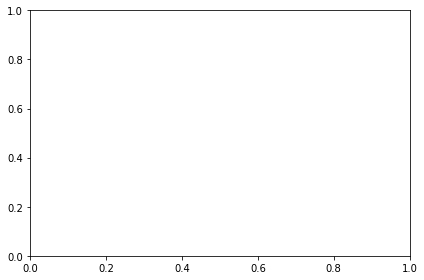

In [44]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
bins = 500
ax.hist(V.flatten(), cumulative=True, bins=bins);
# We can also normalize our inputs by the total number of counts
#axs[1].hist(x, bins=n_bins, density=True)
# Now we format the y-axis to display percentage
vals = ax.get_yticks()
ax.set_yticklabels(['{}'.format(int(100*x/len(V.flatten()))) for i,x in enumerate(vals)])
ax.plot(np.arange(bins+100), np.ones(bins+100)*len(V.flatten())*0.99)
ax.plot(np.arange(bins+100), np.ones(bins+100)*len(V.flatten())*1)
ax.plot(np.arange(bins+100), np.ones(bins+100)*len(V.flatten())*0.5)

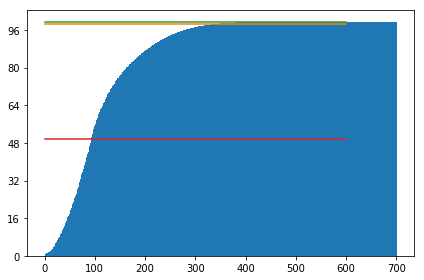

In [15]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
bins = 500
ax.hist(V2.flatten(), cumulative=True, bins=bins);
# We can also normalize our inputs by the total number of counts
#axs[1].hist(x, bins=n_bins, density=True)
# Now we format the y-axis to display percentage
vals = ax.get_yticks()
ax.set_yticklabels(['{}'.format(int(100*x/len(V2.flatten()))) for i,x in enumerate(vals)])
ax.plot(np.arange(bins+100), np.ones(bins+100)*len(V2.flatten())*0.99)
ax.plot(np.arange(bins+100), np.ones(bins+100)*len(V2.flatten())*1)
ax.plot(np.arange(bins+100), np.ones(bins+100)*len(V2.flatten())*0.5)

In [154]:
M_unet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Origin_Input (InputLayer)       (None, 72, 8)        0                                            
__________________________________________________________________________________________________
Conv_0 (Conv1D)                 (None, 72, 64)       5120        Origin_Input[0][0]               
__________________________________________________________________________________________________
elu_0 (ELU)                     (None, 72, 64)       0           Conv_0[0][0]                     
__________________________________________________________________________________________________
Conv_1 (Conv1D)                 (None, 72, 128)      81920       elu_0[0][0]                      
__________________________________________________________________________________________________
elu_1 (ELU

In [110]:
#M_unet.summary()
#W  = M_unet.get_layer('Dense_1').get_weights()
W0 = [W[0]*0, W[1]*0]
M_unet.get_layer('Dense_1').set_weights(W0)

In [152]:
M_unet.get_layer('Dense_1').set_weights(W)

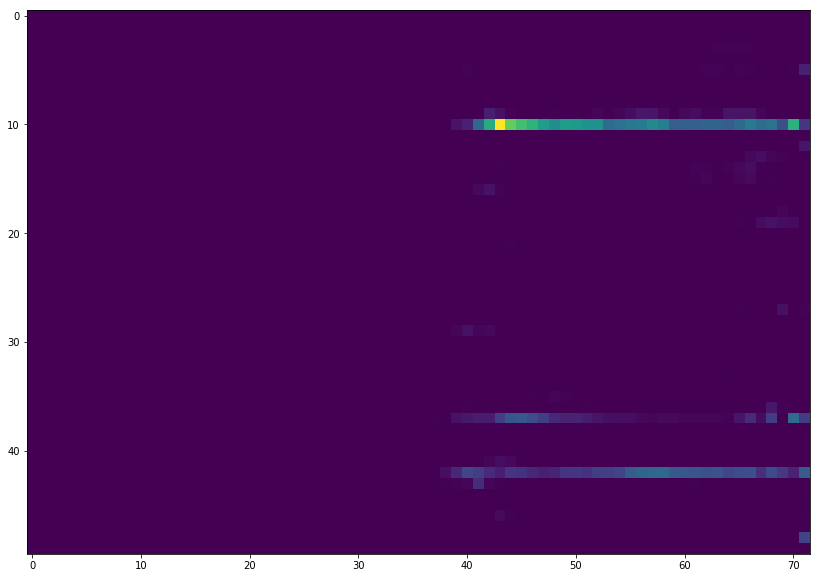

In [171]:
# CHECKING IMPACT OF LOWER LAYER
x,y = validation_generator[100]
y0 = M.predict(x)

i = M_Up.get_input_at(0)
o = M_Up.get_output_at(0)
Up_model = K.function([i],[o])

i1 = M_unet.get_input_at(0)
o1 = M_unet.get_output_at(0)

o2 = M_unet.get_layer('Reshape').output
o3 = M_unet.get_layer('elu_301').get_output_at(0)
o4 = M_unet.get_layer('Conv3_301').get_output_at(0)
o5 = M_unet.get_layer('Conv3_302').get_output_at(0)

Second_model = K.function( [i1],[o1])
Dense_layer = K.function( [i1],[o2])
Antepen_layer = K.function( [i1],[o3])
Last_layer = K.function( [i1],[o4])

#img = Dense_layer(First_model([x]))[0]
img = Antepen_layer(Up_model([x]))[0]
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(111)
ax.imshow((np.mean(abs(img),axis=0).T))

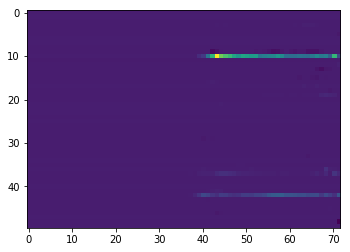

In [185]:
Wl = M_unet.get_layer('Conv3_302').get_weights()
Zeros=Wl[0][1,:,[0]].T*np.mean(abs(img),axis=0).T
plt.imshow(Zeros)

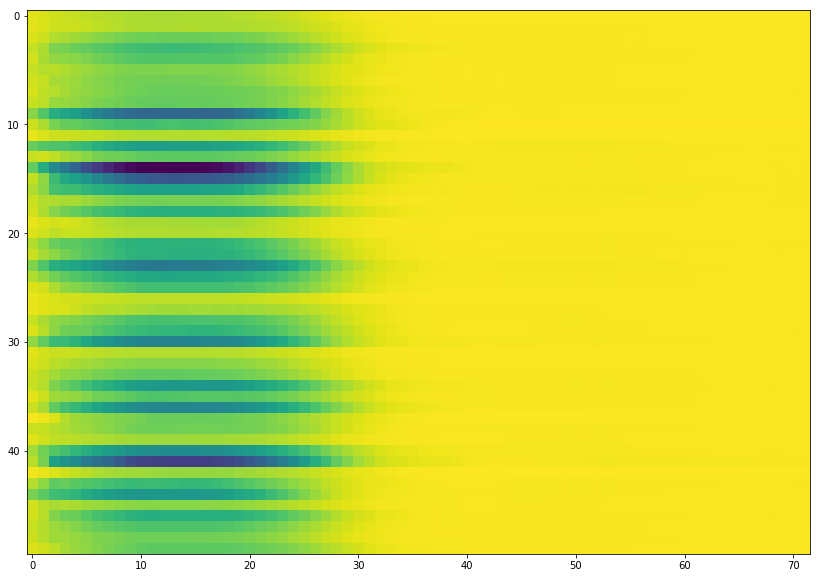

In [186]:
img = Last_layer(Up_model([x]))[0]
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(111)
ax.imshow(np.mean(img,axis=0).T)

(2, 72)


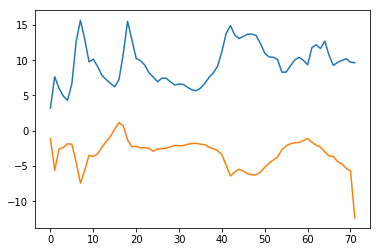

In [120]:
m = np.mean(img,axis=0).T
print(m.shape)
plt.plot(m.T);

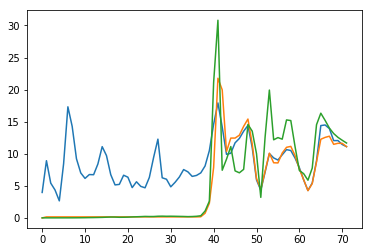

In [151]:
i=25
plt.plot(img[i,:,0]);
plt.plot(y0[i,:,0]);
plt.plot(y[i,:,0]);

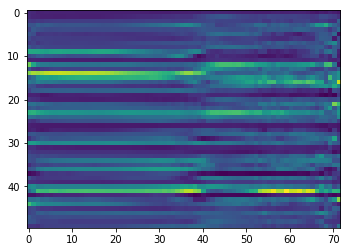

In [115]:
plt.imshow(m/np.mean(m, axis=0))

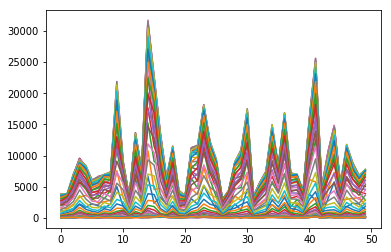

In [114]:
plt.plot(m);

In [64]:
w=M_unet.get_layer('Conv3_302').get_weights()[0]
#plt.imshow(w)

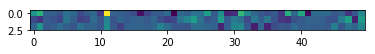

In [66]:
plt.imshow(w[:,:,0]);
plt.imshow(w[:,:,1]);